In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [51]:
#definim una escala de color comu per tots els nostres trees
cmap = cm.RdYlGn
norm = Normalize(vmin=-0.5, vmax=0.5)
#cuncio que convertir RGB a hex
def rgb_to_hex(rgb):
    for i in range(3):
        return ('#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255)))

def replace_color (dot_data, values):
    inici=0
    for i in range(len(values)):
        index=dot_data[inici:].find("fillcolor=")+11+inici
        color=dot_data[index:index+7]
        inici=index+7
        old=color
        new=rgb_to_hex(cmap(norm(values[i]))[:-1])
        dot_data=dot_data.replace(old, new, 1)
    return dot_data

In [3]:
#Read main data to DataFrame
df = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

In [4]:
# "hogarid_old","cp_old","unique_05", "cpmom_06" seran usats com a index
df_out=df[["a5sscore_i_06","a6smemory_p1_06","a6smemory_p2_06","a7a_delay_06","a7b_delay_06",
        "a7c_delay_06","a7d_delay_06","a9sgrossmotor_06","height_06","weight_06","z_tvip_06","z_social_06",
        "z_language_06","z_finmotor_06","z_memory_06","z_grmotor_06","z_legmotor_06","z_behavior_06","z_height_06",
        "z_weight_06","z_all_06"]]


# Income variables

In [5]:
#Read main data to DataFrame
cleaned_df = pd.read_csv('processed_data/cleaned_df.csv', index_col=0)  

In [6]:
df_original = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

df_out=df_original[["a5sscore_i_06","a6smemory_p1_06","a6smemory_p2_06","a7a_delay_06","a7b_delay_06",
        "a7c_delay_06","a7d_delay_06","a9sgrossmotor_06","height_06","weight_06","z_tvip_06","z_social_06",
        "z_language_06","z_finmotor_06","z_memory_06","z_grmotor_06","z_legmotor_06","z_behavior_06","z_height_06",
        "z_weight_06","z_all_06"]]
cleaned_df.drop(cleaned_df[df_out.iloc[cleaned_df.index].z_all_06.isna()].index, axis=0, inplace=True)

In [7]:
cleaned_df["z_all_06"]=df_out.iloc[cleaned_df.index].z_all_06

In [8]:
cp_cols=["hogarid_old"]

In [9]:
cleaned_df.drop(cp_cols, axis=1, inplace=True)

In [10]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = list(cleaned_df.columns)
covariates.remove(treatment)
covariates.remove(outcome)

In [11]:
X=cleaned_df.drop(["z_all_06","tr"], axis=1).copy()
y=cleaned_df.z_all_06
t=cleaned_df.tr

In [40]:
from econml.grf import CausalForest

causal_tree=CausalForest(n_estimators=1, subforest_size=1, max_samples=1., min_samples_leaf=30, max_depth=3,
                         max_features=len(X.columns), criterion="het", inference=False)
causal_tree.fit(X,t,y)

CausalForest(criterion='het', inference=False, max_depth=3, max_features=45,
             max_samples=1.0, min_samples_leaf=30, n_estimators=1,
             subforest_size=1)

In [54]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(causal_tree[0], out_file=None, 
                                feature_names=X.columns, filled=True, rounded=True)

cmap_values=[row[0,0] for row in causal_tree[0].tree_.value]
dot_data=replace_color(dot_data, cmap_values)

#Draw graph
causal_tree_im = graphviz.Source(dot_data, format="png") 

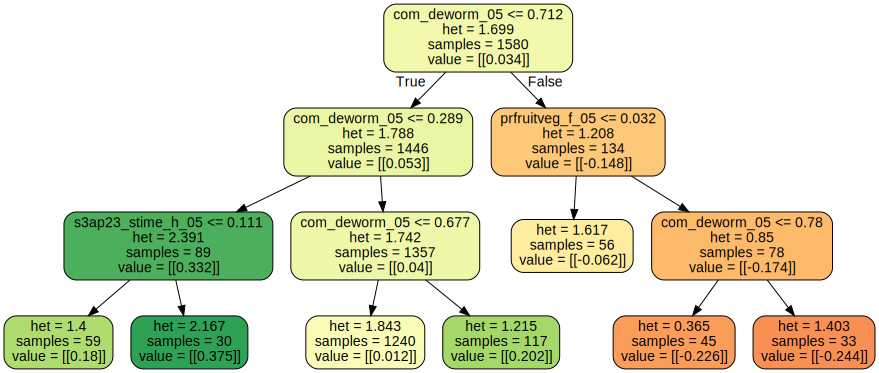

In [55]:
causal_tree_im

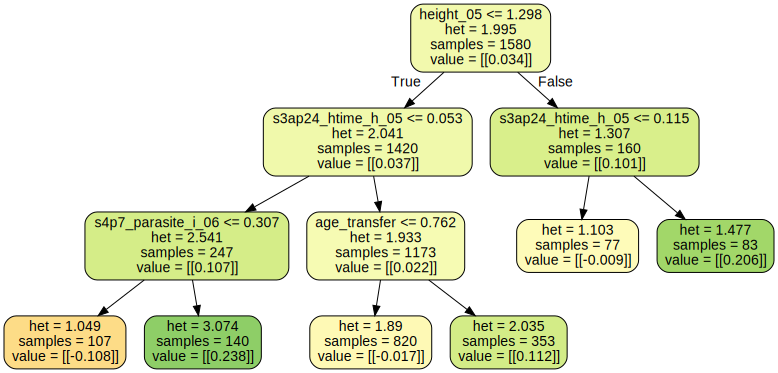

In [56]:
individual_df=cleaned_df[['s1age_head_05', 's1hhsize_05', 's1hhsz_undr5_05', 's1hhsz_5_14_05',
       's1hhsz_15_24_05', 's1hhsz_25_64_05', 's1hhsz_65plus_05',
       's1male_head_05', 's2mother_inhs_05', 's3ap5_rooms_h_05',
       's3ap23_stime_h_05', 's3ap24_htime_h_05', 's3ap25_hqtime_h_05',
       's3atoilet_hh_05', 's3awater_access_hh_05', 's3aelectric_hh_05',
       's4p6_vitamina_i_05', 's4p7_parasite_i_05', 's11ownland_hh_05',
       'cons_food_pc_05', 'cons_tot_pc_05', 'height_05', 'a10whz_05',
       'weight_05', 'yrsedfath', 'age_transfer', 'bweight',
       's4p7_parasite_i_06', 'male', 'ed_mom', 'vitamiron_06', 'propfood_05', 'prstap_f_05',
       'pranimalprot_f_05', 'prfruitveg_f_05']].copy()

X1=individual_df.copy()

causal_tree_ind=CausalForest(n_estimators=1, subforest_size=1, max_samples=1., min_samples_leaf=50, max_depth=3,
                         max_features=len(individual_df.columns), criterion="het", inference=False)
causal_tree_ind .fit(X1,t,y)

dot_data_ind = tree.export_graphviz(causal_tree_ind[0], out_file=None, 
                                feature_names=individual_df.columns, filled=True,rounded=True)

cmap_values=[row[0,0] for row in causal_tree_ind[0].tree_.value]
dot_data_ind=replace_color(dot_data_ind, cmap_values)
#Draw graph
causal_ind_im= graphviz.Source(dot_data_ind, format="png") 
causal_ind_im